In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.utils import preprocessing as pp
from adjoint_esn.utils.enums import eParam
from adjoint_esn.rijke_galerkin.solver import Rijke
from functools import partial
from adjoint_esn.utils.discretizations import finite_differences
import adjoint_esn.utils.solve_ode as solve_ode
from pathlib import Path

In [2]:
def acoustic_energy(y, N_g):
    return 1/4*np.mean(np.sum(y[:,:2*N_g]**2, axis = 1))

In [3]:
def acoustic_energy_cum(y, N_g):
    return 1/4*np.cumsum(np.sum(y[:,:2*N_g]**2, axis = 1))/np.arange(1,len(y)+1)

In [4]:
def true_direct_sensitivity(my_rijke, t_bar, y_bar, integrator='odeint'):
    dt = t_bar[1]-t_bar[0]
    # direct problem
    dir0 = np.zeros(2*my_rijke.N_dim+2)
    dir = solve_ode.integrate(my_rijke.direct_ode,
                              dir0,
                              t_bar,
                              integrator=integrator,
                              args=(t_bar,1/dt,y_bar))
    dJdp = 1/t_bar[-1]*dir[-1,-2:]
    return dJdp

def true_adjoint_sensitivity(my_rijke, t_bar, y_bar, integrator='odeint'):
    dt = t_bar[1]-t_bar[0]
    # adjoint problem
    adjT = np.zeros(my_rijke.N_dim+2)
    adj = solve_ode.integrate(my_rijke.adjoint_ode,
                              adjT,
                              np.flip(t_bar),
                              integrator=integrator,
                              args =(t_bar,1/dt,y_bar))
    dJdp  = 1/t_bar[-1]*adj[-1,-2:]
    return dJdp

def true_finite_difference_sensitivity(my_rijke, t_bar, y_bar, h, h_tau, method, integrator='odeint'):
    # Calculate numerically
    # Find perturbed solutions (in beta)
    dJdp = np.zeros((2,))

    # left solution with beta = beta-h
    my_rijke_beta_left = Rijke(N_g=my_rijke.N_g,N_c=my_rijke.N_c,c_1=0.1,c_2=0.06,beta=my_rijke.beta-h,x_f=my_rijke.x_f,tau=my_rijke.tau,
                     heat_law="kings_poly",damping="modal")

    y_bar_beta_left =  solve_ode.integrate(my_rijke_beta_left.ode,
                                           y_bar[0,:my_rijke.N_dim],
                                           t_bar,
                                           integrator=integrator)
    J_beta_left = acoustic_energy(y_bar_beta_left[1:,:], my_rijke.N_g)
        
    # right solution with beta = beta+h
    my_rijke_beta_right = Rijke(N_g=my_rijke.N_g,N_c=my_rijke.N_c,c_1=0.1,c_2=0.06,beta=my_rijke.beta+h,x_f=my_rijke.x_f,tau=my_rijke.tau,
                     heat_law="kings_poly",damping="modal")
    
    y_bar_beta_right = solve_ode.integrate(my_rijke_beta_right.ode,
                                           y_bar[0,:my_rijke.N_dim],
                                           t_bar,
                                           integrator=integrator)
    J_beta_right = acoustic_energy(y_bar_beta_right[1:,:], my_rijke.N_g)

    # left solution with tau = tau-h
    my_rijke_tau_left = Rijke(N_g=my_rijke.N_g,N_c=my_rijke.N_c,c_1=0.1,c_2=0.06,beta=my_rijke.beta,x_f=my_rijke.x_f,tau=my_rijke.tau-h_tau,
                     heat_law="kings_poly",damping="modal")

    y_bar_tau_left = solve_ode.integrate(my_rijke_tau_left.ode,
                                         y_bar[0,:my_rijke.N_dim],
                                         t_bar,
                                         integrator=integrator)
    J_tau_left = acoustic_energy(y_bar_tau_left[1:,:], my_rijke.N_g)
        
    # # right solution with tau = tau+h
    my_rijke_tau_right = Rijke(N_g=my_rijke.N_g,N_c=my_rijke.N_c,c_1=0.1,c_2=0.06,beta=my_rijke.beta,x_f=my_rijke.x_f,tau=my_rijke.tau+h_tau,
                     heat_law="kings_poly",damping="modal")
    
    y_bar_tau_right = solve_ode.integrate(my_rijke_tau_right.ode,
                                          y_bar[0,:my_rijke.N_dim],
                                          t_bar,
                                          integrator=integrator)
    J_tau_right = acoustic_energy(y_bar_tau_right[1:,:], my_rijke.N_g)

    # define which finite difference method to use
    finite_difference = partial(finite_differences, method=method)

    J = acoustic_energy(y_bar[1:,:],my_rijke.N_g)
    dJdp[eParam.beta] = finite_difference(J, J_beta_right, J_beta_left, h)
    dJdp[eParam.tau] = finite_difference(J, J_tau_right, J_tau_left, h_tau)
    return dJdp


In [48]:
integrator = 'odeint'
transient_time = 200
for sim_time in transient_time+np.array([1000]):
    print('Sim time = ', sim_time-transient_time)
    sim_dt = 1e-3
    data_dir=Path('..\data')
    N_g = 4
    beta_list = np.arange(7.14,7.21,0.01)
    tau_list = [0.2]

    p_list = pp.make_param_mesh([beta_list,tau_list])

    finite_difference_method = 'central'
    methods = ['numerical']
    dJdp = {'true':{}}
    for method_name in methods:
        dJdp['true'][method_name] = np.zeros((len(p_list),2))

    J = {'true':np.zeros(len(p_list))}
    J_cum = {'true':[None]*len(p_list)}

    for p_idx, p in enumerate(p_list):
        p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}

        regime_str = f'beta = {p_sim["beta"]}, tau = {p_sim["tau"]}'
        print('Regime:',regime_str)
        
        y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                    sim_time=sim_time,sim_dt=sim_dt,
                                    data_dir=data_dir,
                                    integrator=integrator)

        N_transient = pp.get_steps(transient_time,sim_dt)
        y_bar = y_sim[N_transient:,:]
        t_bar = t_sim[N_transient:]-t_sim[N_transient]

        my_rijke = Rijke(
                N_g=N_g,
                N_c=10,
                c_1=0.1,
                c_2=0.06,
                beta=p_sim["beta"],
                x_f=0.2,
                tau=p_sim["tau"],
                heat_law="kings_poly",
                damping="modal",
            )

        J["true"][p_idx] = acoustic_energy(y_bar[1:,:], N_g)
        J_cum["true"][p_idx] = acoustic_energy_cum(y_bar[1:,:], N_g)
        
        # plt.figure(figsize=(15,5))
        # plt.subplot(1,3,1)
        # plt.plot(t_bar,y_bar[:,0])
        # plt.subplot(1,3,2)
        # plt.plot(t_bar,y_bar[:,1])
        # plt.subplot(1,3,3)
        # plt.plot(t_bar,y_bar[:,2])
        # plt.suptitle(regime_str)

        # for method_name in methods:
        #     if method_name == "direct":
        #         dJdp["true"][method_name][p_idx]= true_direct_sensitivity(my_rijke, t_bar, y_bar, integrator)
        #     elif method_name == "adjoint":
        #         dJdp["true"][method_name][p_idx]= true_adjoint_sensitivity(my_rijke, t_bar, y_bar, integrator)
        #     elif method_name == "numerical":
        #         dJdp["true"][method_name][p_idx]= true_finite_difference_sensitivity(my_rijke, t_bar, 
        #                                                                             y_bar, 
        #                                                                             h=1e-3, 
        #                                                                             h_tau=1e-3, 
        #                                                                             method=finite_difference_method,
        #                                                                             integrator=integrator)
        #     print(f'True dJ/dp, {method_name} = {dJdp["true"][method_name][p_idx]}')
        

Sim time =  1000
Regime: beta = 7.14, tau = 0.2
Regime: beta = 7.1499999999999995, tau = 0.2
Regime: beta = 7.159999999999999, tau = 0.2
Regime: beta = 7.169999999999999, tau = 0.2
Regime: beta = 7.179999999999999, tau = 0.2
Regime: beta = 7.189999999999999, tau = 0.2
Regime: beta = 7.199999999999998, tau = 0.2
Regime: beta = 7.209999999999998, tau = 0.2


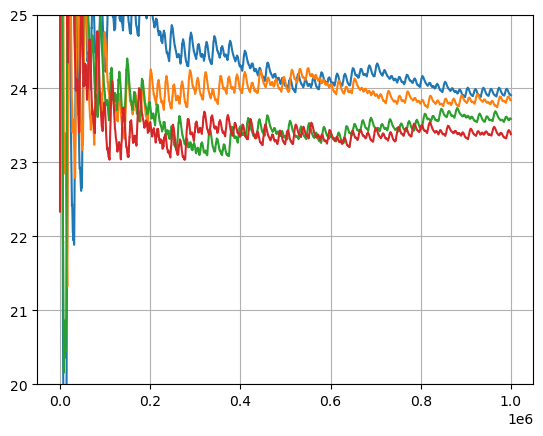

In [49]:
plt.figure()
plt.plot(J_cum["true"][0])
plt.plot(J_cum["true"][1])
plt.plot(J_cum["true"][2])
plt.plot(J_cum["true"][3])
plt.grid()
plt.ylim([20,25])
plt.show()

Text(0, 0.5, 'dJ/dbeta')

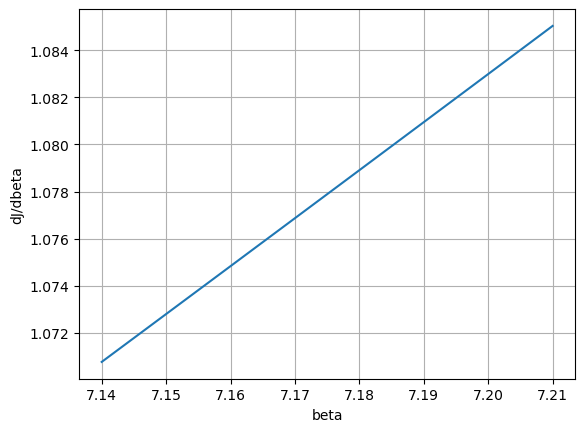

In [15]:
plt.plot(p_list[:,0],J["true"])
# plt.plot(p_list[:,0],J["true"])
plt.grid()
plt.xlabel('beta')
plt.ylabel('dJ/dbeta')

In [ ]:
integrator = 'odeint'

sim_dt = 1e-3
data_dir=Path('..\data')
N_g = 4
beta_list = np.arange(7.19,7.201,0.001)
tau_list = [0.2]

p_list = pp.make_param_mesh([beta_list,tau_list])

finite_difference_method = 'central'
methods = ['adjoint']

transient_time = 0
integration_time = 2000
sim_time = transient_time+integration_time

print('Integration time = ', sim_time-transient_time)

dJdp = {'true':{}}

n_ensemble = 1
J = {'true':np.zeros((len(p_list),n_ensemble))}

for method_name in methods:
    dJdp['true'][method_name] = np.zeros((len(p_list),2,n_ensemble))

for p_idx, p in enumerate(p_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}

    regime_str = f'beta = {p_sim["beta"]}, tau = {p_sim["tau"]}'
    print('Regime:',regime_str)

    my_rijke = Rijke(
            N_g=N_g,
            N_c=10,
            c_1=0.1,
            c_2=0.06,
            beta=p_sim["beta"],
            x_f=0.2,
            tau=p_sim["tau"],
            heat_law="kings_poly",
            damping="modal",
        )
    
    for e_idx in range(n_ensemble):
        # run simulation
        # rnd = np.random.RandomState(seed=e_idx)
        # y0 = rnd.randn(my_rijke.N_dim)

        # run simulation
        y0 = np.zeros(my_rijke.N_dim)
        y0[0] = 1.0

        # temporal grid
        t_sim = np.arange(0, sim_time + sim_dt, sim_dt)

        # solve ODE using odeint
        y_sim = solve_ode.integrate(my_rijke.ode, y0, t_sim, integrator)

        N_transient = pp.get_steps(transient_time,sim_dt)
        y_bar = y_sim[N_transient:,:]
        t_bar = t_sim[N_transient:]-t_sim[N_transient]


        J["true"][p_idx,e_idx] = acoustic_energy(y_bar[1:,:], N_g)
        print(f'True J = {J["true"][p_idx,e_idx]}')
        # for method_name in methods:
        #     if method_name == "direct":
        #         dJdp["true"][method_name][p_idx,:,e_idx]= true_direct_sensitivity(my_rijke, t_bar, y_bar, integrator)
        #     elif method_name == "adjoint":
        #         dJdp["true"][method_name][p_idx,:,e_idx]= true_adjoint_sensitivity(my_rijke, t_bar, y_bar, integrator)
        #     elif method_name == "numerical":
        #         dJdp["true"][method_name][p_idx,:,e_idx]= true_finite_difference_sensitivity(my_rijke, t_bar, 
        #                                                                             y_bar, 
        #                                                                             h=1e-5, 
        #                                                                             h_tau=1e-5, 
        #                                                                             method=finite_difference_method,
        #                                                                             integrator=integrator)
        #     print(f'True dJ/dp, {method_name} = {dJdp["true"][method_name][p_idx,:,e_idx]}')

Text(0, 0.5, 'dJ/dbeta')

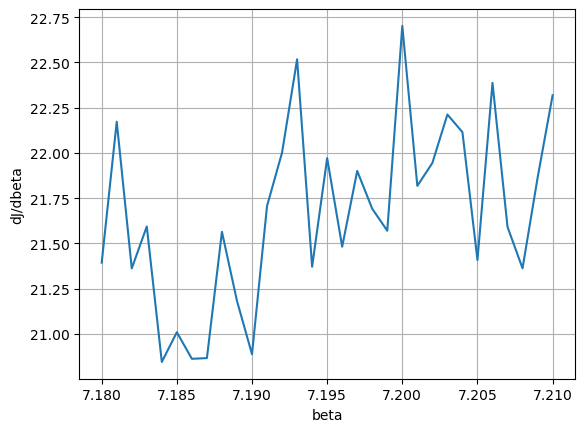

In [21]:
# plt.plot(p_list[:,0],np.mean(J["true"],axis=1))
plt.plot(p_list[:,0],J["true"])
plt.grid()
plt.xlabel('beta')
plt.ylabel('dJ/dbeta')

Text(0, 0.5, 'dJ/dbeta')

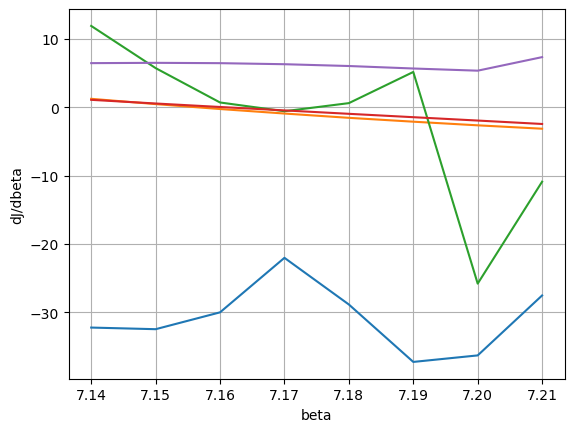

In [30]:
plt.plot(p_list[:,0],dJdp["true"]["adjoint"][:,0,:])
plt.grid()
plt.xlabel('beta')
plt.ylabel('dJ/dbeta')

Text(0, 0.5, 'dJ/dbeta')

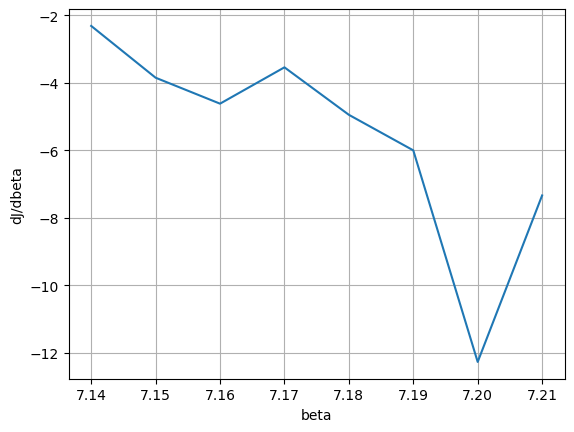

In [31]:
plt.plot(p_list[:,0],np.mean(dJdp["true"]["adjoint"][:,0,:], axis = -1))
plt.grid()
plt.xlabel('beta')
plt.ylabel('dJ/dbeta')

Text(0, 0.5, 'J')

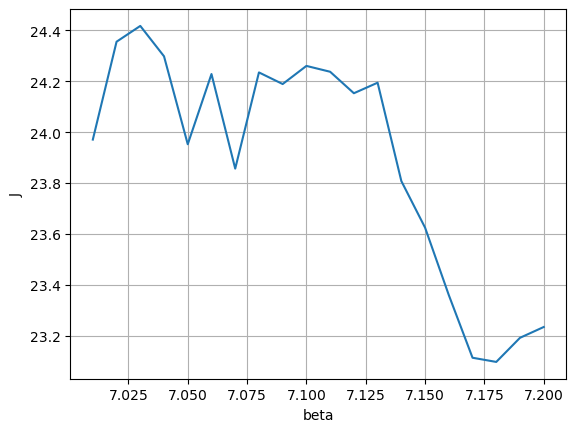

In [60]:
from_idx = 0
end_idx = -1
plt.figure()
# plt.scatter(p_list[from_idx:end_idx,0],J["true"][from_idx:end_idx], s=5)
plt.plot(p_list[from_idx:end_idx,0],J["true"][from_idx:end_idx])
plt.grid()
plt.xlabel('beta')
plt.ylabel('J')

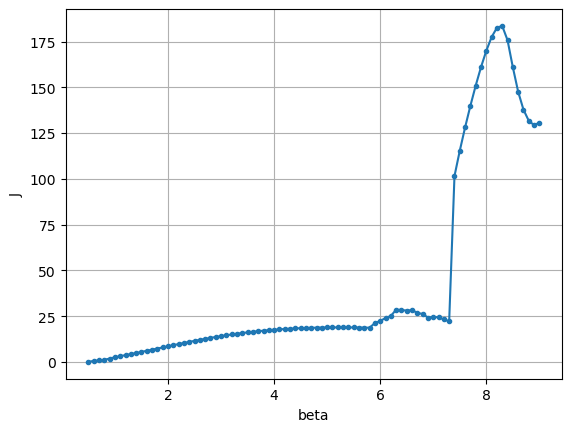

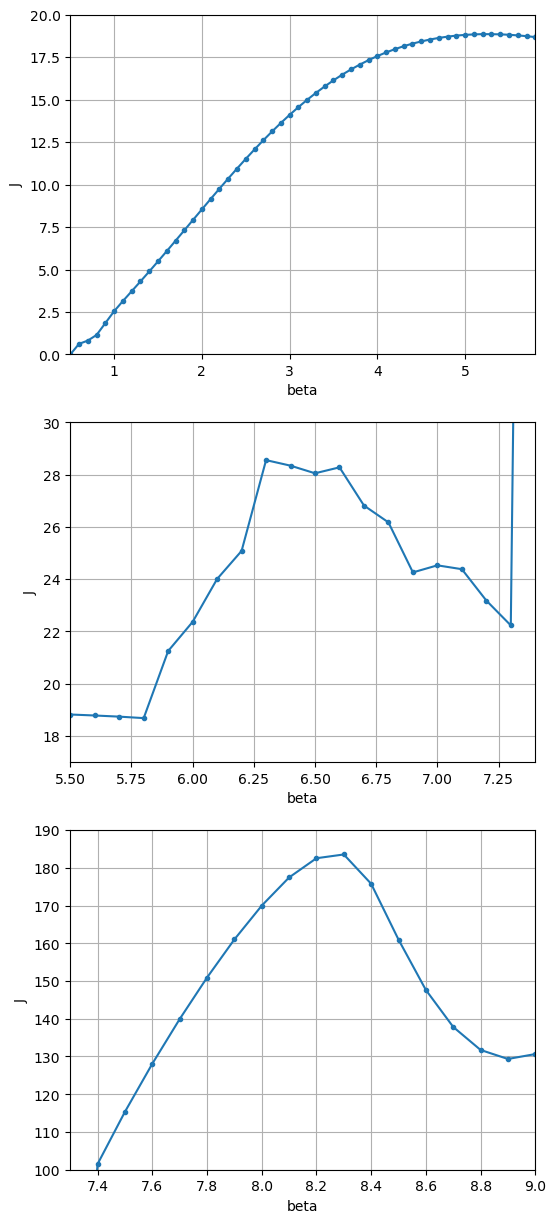

In [12]:
plt.figure()
plt.plot(p_list[:,0],J["true"], '-o', markersize=3)
# plt.ylim([17,30])
plt.grid()
plt.xlabel('beta')
plt.ylabel('J')
plt.show()

plt.figure(figsize=(6,15))
plt.subplot(3,1,1)
plt.plot(p_list[:,0],J["true"], '-o', markersize=3)
plt.xlim([0.5,5.8])
plt.ylim([0,20])
plt.xlabel('beta')
plt.ylabel('J')
plt.grid()

plt.subplot(3,1,2)
plt.plot(p_list[:,0],J["true"], '-o', markersize=3)
plt.xlim([5.5,7.4])
plt.ylim([17,30])
plt.xlabel('beta')
plt.ylabel('J')
plt.grid()

plt.subplot(3,1,3)
plt.plot(p_list[:,0],J["true"], '-o', markersize=3)
plt.xlim([7.3,9.0])
plt.ylim([100,190])
plt.xlabel('beta')
plt.ylabel('J')
plt.grid()
plt.show()

In [28]:
J_cum_array = np.array(J_cum["true"])

In [8]:
J_cum_array.shape[1]

1000000

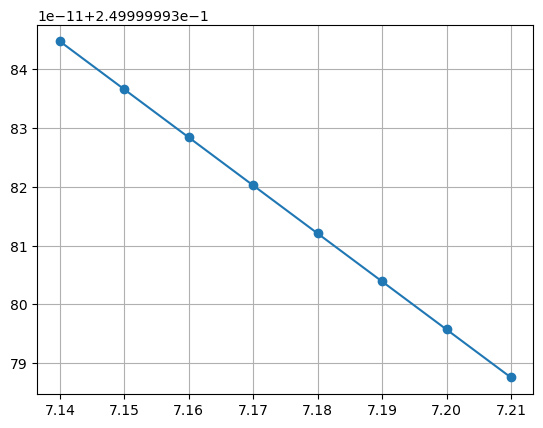

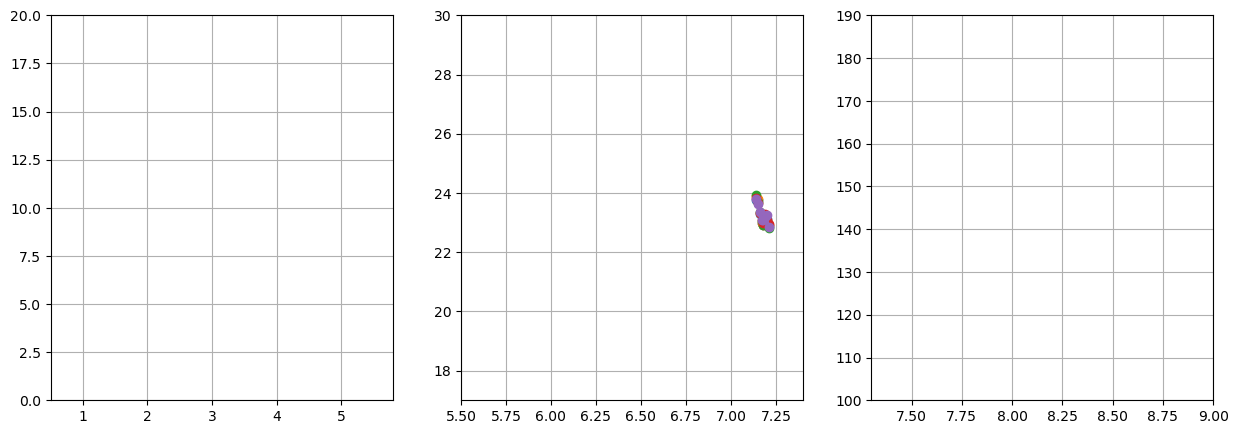

In [29]:
plt.figure()
plt.plot(p_list[:,0],J_cum_array[:,0],'-o')
# plt.ylim([17,30])
plt.grid()
plt.show()

fig = plt.figure(figsize=(15,5))
axs = fig.subplots(1,3)
plt_times = [800,850,900,950,999]
plt_time_idxs = [pp.get_steps(plt_time, sim_dt) for plt_time in plt_times]
for idx in plt_time_idxs:
    axs[0].plot(p_list[:,0],J_cum_array[:,idx],'-o')
    axs[0].set_xlim([0.5,5.8])
    axs[0].set_ylim([0,20])
    axs[0].grid()

    axs[1].plot(p_list[:,0],J_cum_array[:,idx],'-o')
    axs[1].set_xlim([5.5,7.4])
    axs[1].set_ylim([17,30])
    axs[1].grid()

    axs[2].plot(p_list[:,0],J_cum_array[:,idx],'-o')
    axs[2].set_xlim([7.3,9.0])
    axs[2].set_ylim([100,190])
    axs[2].grid()

In [ ]:
for i in range(len(p_list)):
    plt.plot(J_cum["true"][i])
# plt.legend(p_list[:,0])
# plt.ylim([14.1,14.11])